In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "median-housing-prices"

In [2]:
library(fpp3)
library(dplyr)
library(fable)
library(ggplot2)
library(forecast)

── Attaching packages ────────────────────────────────────────────── fpp3 0.5 ──

✔ tsibble     1.1.3     ✔ fable       0.3.3
✔ tsibbledata 0.4.1     ✔ fabletools  0.3.3
✔ feasts      0.3.1     

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:fabletools’:

    accuracy




In [3]:
data_raw <- read.csv("/kaggle/input/median-housing-prices/MSPUS.csv", header = TRUE)

In [4]:
head(data_raw, 10)

,DATE,MSPUS
,<chr>,<dbl>
1,1963-01-01,17800
2,1963-04-01,18000
3,1963-07-01,17900
4,1963-10-01,18500
5,1964-01-01,18500
6,1964-04-01,18900
7,1964-07-01,18900
8,1964-10-01,19400
9,1965-01-01,20200


In [5]:
data_raw$DATE <- as.Date(data_raw$DATE)

In [6]:
house_ts <- data_raw %>%
mutate(DATE = yearquarter(DATE)) %>%
as_tsibble(index = DATE)

In [7]:
colnames(house_ts) <- c("quarter", "price")

In [8]:
head(house_ts)

quarter,price
<qtr>,<dbl>
1963 Q1,17800
1963 Q2,18000
1963 Q3,17900
1963 Q4,18500
1964 Q1,18500
1964 Q2,18900


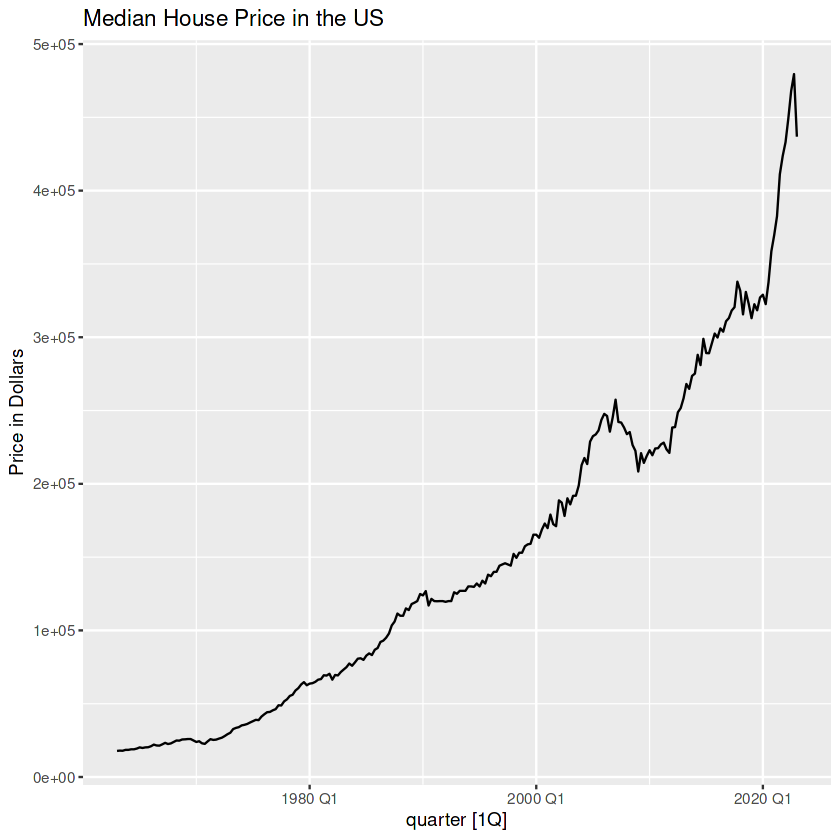

In [9]:
house_ts %>%
autoplot(price) + labs(title = "Median House Price in the US", y = "Price in Dollars")

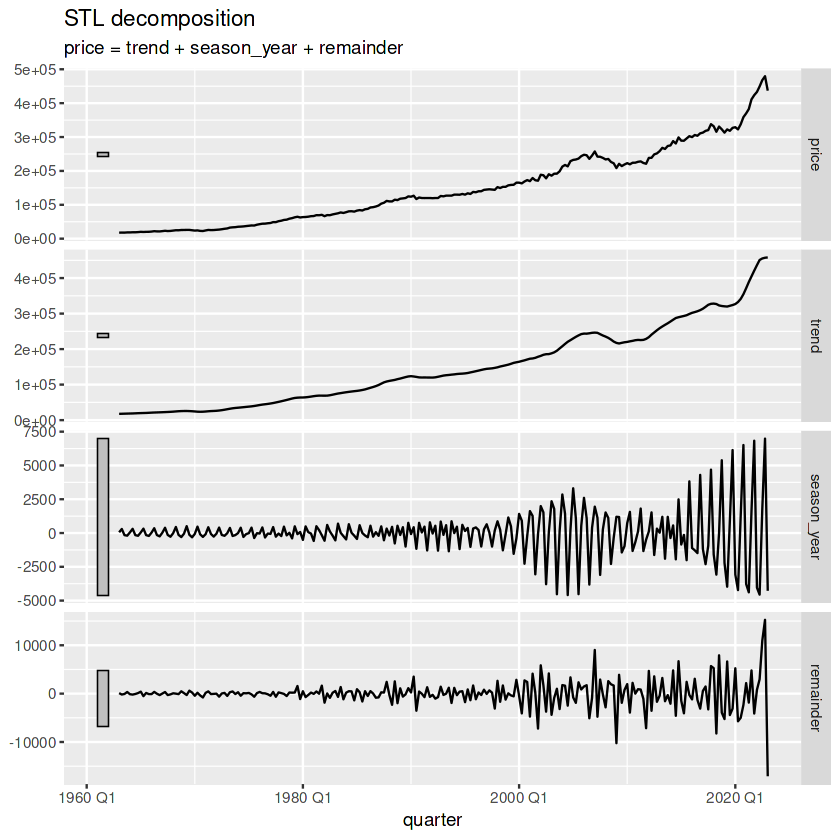

In [10]:
house_stl <- house_ts %>%
model(stl = STL(price))
components(house_stl)%>%
autoplot()

In [11]:
house_stl <- house_ts %>%
model(stl = STL(price))
head(components(house_stl),10)

.model,quarter,price,trend,season_year,remainder,season_adjust
<chr>,<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
stl,1963 Q1,17800,17639.12,52.73841,108.13909,17747.26
stl,1963 Q2,18000,17887.26,298.22342,-185.48149,17701.78
stl,1963 Q3,17900,18122.83,-157.92848,-64.90099,18057.93
stl,1963 Q4,18500,18359.71,-195.64101,335.92843,18695.64
stl,1964 Q1,18500,18570.80,47.41067,-118.20979,18452.59
stl,1964 Q2,18900,18786.18,311.03250,-197.21078,18588.97
stl,1964 Q3,18900,19126.99,-156.43176,-70.56180,19056.43
stl,1964 Q4,19400,19491.55,-204.93890,113.38402,19604.94
stl,1965 Q1,20200,19750.99,42.15860,406.85480,20157.84


In [12]:
tail(house_ts, 20)

quarter,price
<qtr>,<dbl>
2018 Q2,315600
2018 Q3,330900
2018 Q4,322800
2019 Q1,313000
2019 Q2,322500
2019 Q3,318400
2019 Q4,327100
2020 Q1,329000
2020 Q2,322600


In [13]:
head(house_ts)

quarter,price
<qtr>,<dbl>
1963 Q1,17800
1963 Q2,18000
1963 Q3,17900
1963 Q4,18500
1964 Q1,18500
1964 Q2,18900


In [14]:
train <- house_ts %>%
filter_index("1963 Q1" ~ "2016 Q3")
test <- house_ts%>%
filter_index("2016 Q4" ~ "2023 Q1")

In [15]:
test

quarter,price
<qtr>,<dbl>
2016 Q4,310900
2017 Q1,313100
2017 Q2,318200
2017 Q3,320500
2017 Q4,337900
2018 Q1,331800
2018 Q2,315600
2018 Q3,330900
2018 Q4,322800


In [16]:
lambda <- train %>%
  features(price, features = guerrero) %>%
  pull(lambda_guerrero)
lambda

[1] 0.1711386

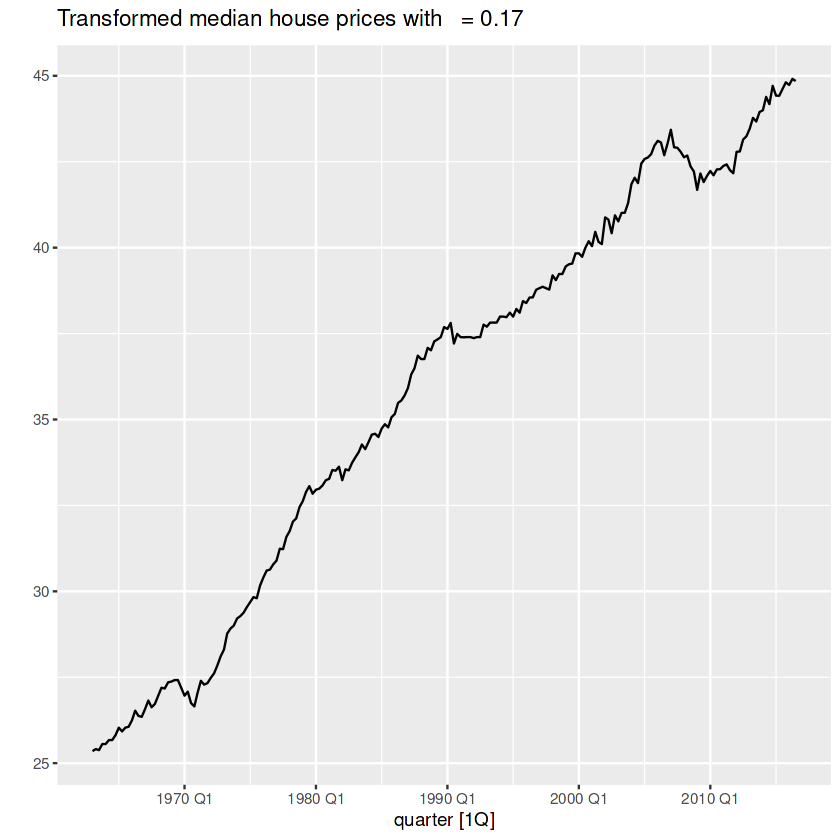

In [17]:
train %>%
  autoplot(box_cox(price, lambda)) +
  labs(y = "",
       title = latex2exp::TeX(paste0(
         "Transformed median house prices with $\\lambda$ = ",
         round(lambda,2))))

In [18]:
tail(train)

quarter,price
<qtr>,<dbl>
2015 Q2,289100
2015 Q3,295800
2015 Q4,302500
2016 Q1,299800
2016 Q2,306000
2016 Q3,303800


In [19]:
head(test)

quarter,price
<qtr>,<dbl>
2016 Q4,310900
2017 Q1,313100
2017 Q2,318200
2017 Q3,320500
2017 Q4,337900
2018 Q1,331800


# **Exponential Smoothing Model**

In [20]:
ets_fit <- train%>%
model(ETS(price))%>%
report()

Series: price 
Model: ETS(M,A,M) 
  Smoothing parameters:
    alpha = 0.7394349 
    beta  = 0.1338407 
    gamma = 0.0001000092 

  Initial states:
     l[0]     b[0]     s[0]     s[-1]   s[-2]    s[-3]
 17380.98 253.2386 0.998772 0.9921066 1.00783 1.001292

  sigma^2:  7e-04

     AIC     AICc      BIC 
4516.468 4517.346 4546.803 


In [21]:
ets_fit_tr <- train %>%
model(ETS(box_cox(price, lambda)))%>%
report()

Series: price 
Model: ETS(M,Ad,A) 
Transformation: box_cox(price, lambda) 
  Smoothing parameters:
    alpha = 0.6093809 
    beta  = 0.2075147 
    gamma = 0.0001000216 
    phi   = 0.9397297 

  Initial states:
     l[0]      b[0]        s[0]      s[-1]      s[-2]       s[-3]
 25.25979 0.1056943 -0.01201012 -0.0503661 0.05626064 0.006115587

  sigma^2:  0

     AIC     AICc      BIC 
450.3938 451.4722 484.1002 


In [22]:
ets_fit_tr <- train%>%
model(ETS(box_cox(price, lambda) ~ error("M") + trend("Ad", phi = 0.9397297) + season("M")))

In [23]:
ets_fit_tr

"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))"
<model>
"<ETS(M,Ad,M)>"


In [24]:
ets_fc <- ets_fit_tr%>%
forecast(h=26)
ets_fc

.model,quarter,price,.mean
<chr>,<qtr>,<dist>,<dbl>
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2016 Q4,"t(N(45, 0.063))",308860.4
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2017 Q1,"t(N(45, 0.11))",311969.7
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2017 Q2,"t(N(45, 0.2))",316676.2
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2017 Q3,"t(N(45, 0.34))",313016.5
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2017 Q4,"t(N(45, 0.53))",318688.1
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2018 Q1,"t(N(45, 0.79))",321688.5
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2018 Q2,"t(N(45, 1.1))",326410.7
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2018 Q3,"t(N(45, 1.5))",322566.7
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",2018 Q4,"t(N(45, 2))",328400.0


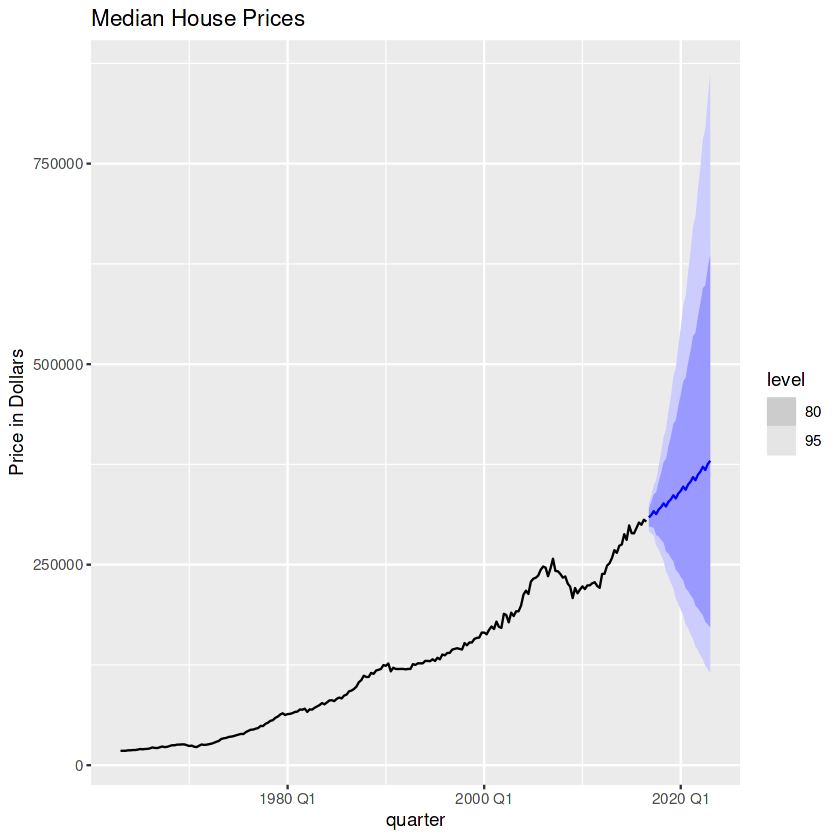

In [25]:
fit <- train %>%
model(ETS(box_cox(price, lambda) ~ error("M") + trend("Ad", phi = 0.9397297) + season("M")))%>%
  forecast(h = 26) %>%
  autoplot(train)+
  labs(title="Median House Prices",
       y="Price in Dollars")
fit

In [26]:
fabletools::accuracy(ets_fc, test)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ETS(box_cox(price, lambda) ~ error(""M"") + trend(""Ad"", phi = 0.9397297) + season(""M""))",Test,19325.98,41489.81,28435.95,4.158029,6.989552,NaN,NaN,0.8867164


# **ARIMA**

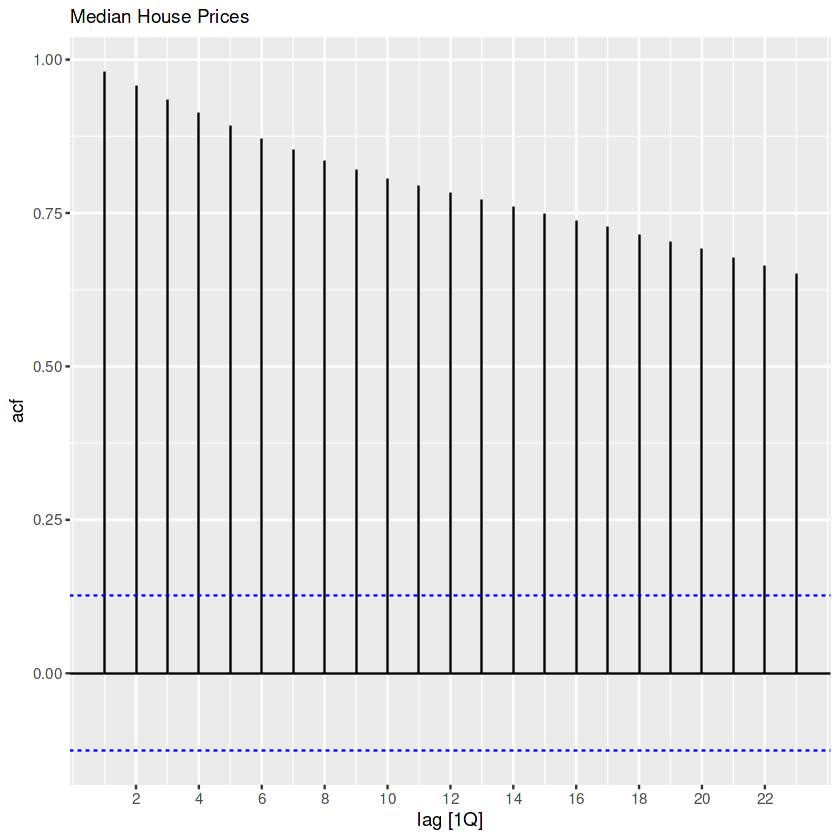

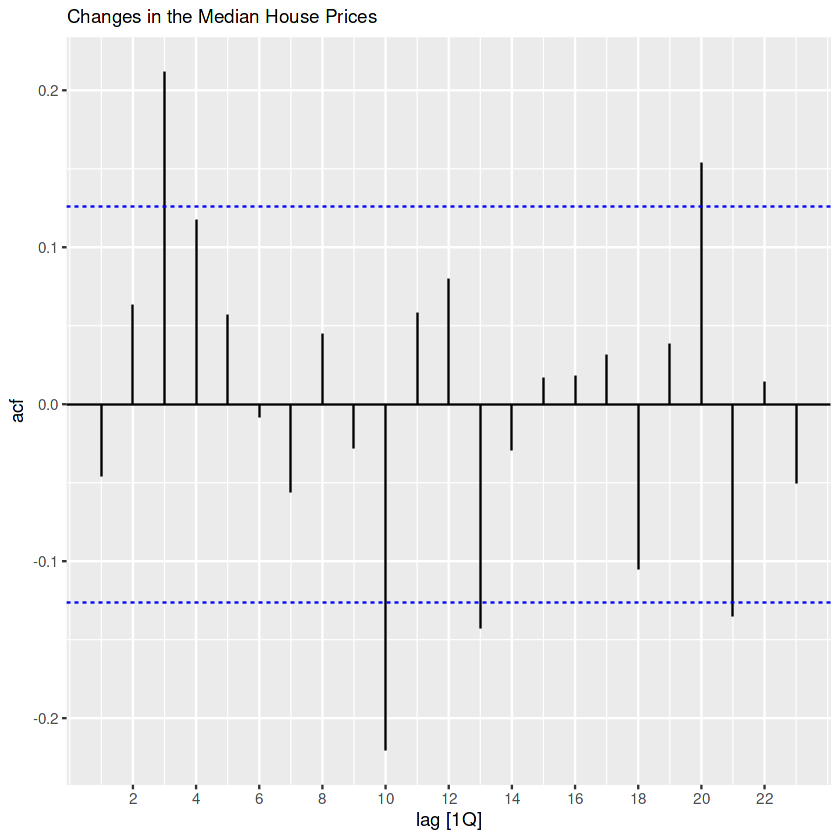

In [27]:
house_ts %>%
ACF(price) %>%
autoplot() + labs(subtitle = "Median House Prices")

house_ts %>%
ACF(difference(price)) %>%
autoplot() + labs(subtitle = "Changes in the Median House Prices")

In [28]:
house_ts %>%
  mutate(diff_price = difference(price)) %>%
  features(diff_price, ljung_box, lag = 24)

lb_stat,lb_pvalue
<dbl>,<dbl>
54.1238,0.0004103343


In [29]:
house_ts %>%
features(price,unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
4.615101,0.01


In [30]:
house_ts %>%
mutate(diff_price = difference(price)) %>%
features(diff_price,unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.5977656,0.02283949


In [31]:
house_ts %>%
features(price,unitroot_ndiffs)

ndiffs
<int>
2


In [32]:
house_ts %>%
mutate(diff_price = difference(difference(price))) %>%
features(diff_price,unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.1301671,0.1


In [33]:
house_ts %>%
mutate(diff_price = difference(log(price))) %>%
features(diff_price,unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.3040047,0.1


In [34]:
house_ts %>%
mutate(log_price = log(price)) %>%
features(log_price, unitroot_nsdiffs)

nsdiffs
<int>
0


In [35]:
head(house_ts)

quarter,price
<qtr>,<dbl>
1963 Q1,17800
1963 Q2,18000
1963 Q3,17900
1963 Q4,18500
1964 Q1,18500
1964 Q2,18900


Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


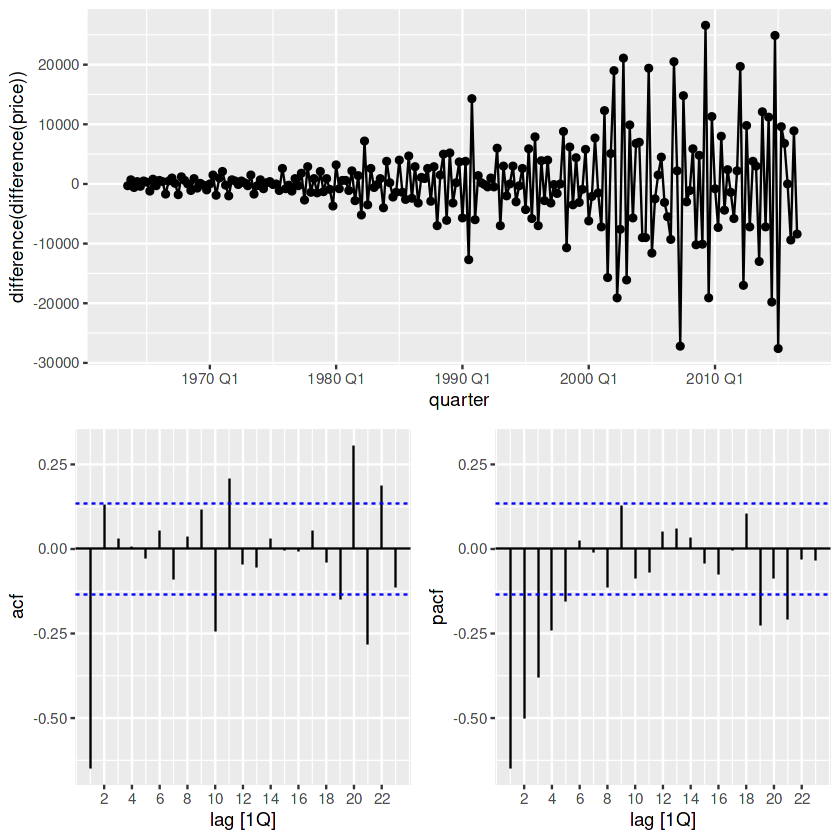

In [36]:
train %>%
  gg_tsdisplay(difference(difference(price)), plot_type='partial')

In [37]:
train_tf <- train %>%
  mutate(price = BoxCox(price, lambda))

In [38]:
head(train_tf)

quarter,price
<qtr>,<dbl>
1963 Q1,25.35019
1963 Q2,25.40990
1963 Q3,25.38012
1963 Q4,25.55679
1964 Q1,25.55679
1964 Q2,25.67195


In [39]:
arima_fit <- train_tf %>%
model(ARIMA(price))%>%
report()

Series: price 
Model: ARIMA(0,1,4) w/ drift 

Coefficients:
          ma1     ma2     ma3     ma4  constant
      -0.2853  0.1109  0.1545  0.1084    0.0910
s.e.   0.0678  0.0711  0.0695  0.0624    0.0144

sigma^2 estimated as 0.0385:  log likelihood=47.24
AIC=-82.49   AICc=-82.08   BIC=-62.29


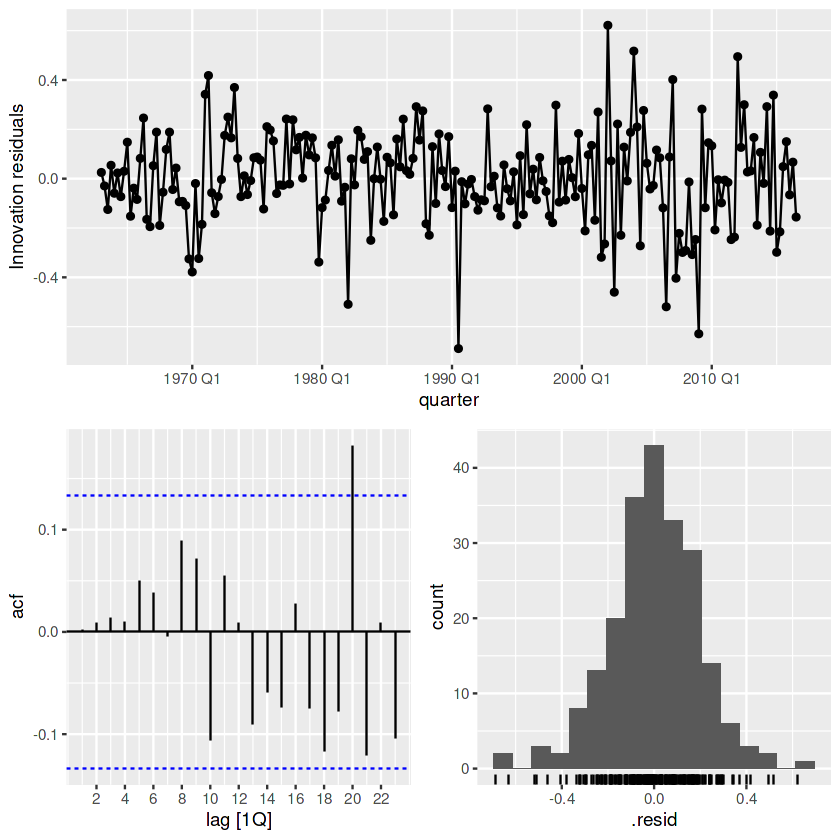

In [40]:
arima_fit %>%
  gg_tsresiduals()

In [41]:
augment(arima_fit) %>%
features(.resid, ljung_box, lag = 24, dof = 4)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
ARIMA(price),31.55724,0.04825069


The ACF of the residuals resemble white noise to some extent as the p-value is not that far off from 0.05, hence moving on to make predictions of forecasts.

In [42]:
arima_fc <- arima_fit %>% forecast(h=26)
arima_fc

.model,quarter,price,.mean
<chr>,<qtr>,<dist>,<dbl>
ARIMA(price),2016 Q4,"N(45, 0.039)",44.99714
ARIMA(price),2017 Q1,"N(45, 0.058)",45.07408
ARIMA(price),2017 Q2,"N(45, 0.084)",45.14826
ARIMA(price),2017 Q3,"N(45, 0.12)",45.22237
ARIMA(price),2017 Q4,"N(45, 0.17)",45.31335
ARIMA(price),2018 Q1,"N(45, 0.21)",45.40434
ARIMA(price),2018 Q2,"N(45, 0.26)",45.49532
ARIMA(price),2018 Q3,"N(46, 0.3)",45.58631
ARIMA(price),2018 Q4,"N(46, 0.35)",45.67729


In [43]:
# Reverse the Box-Cox transformation to obtain forecasts on the original scale
fc_orig <- arima_fc %>%
  mutate(.mean = InvBoxCox(.mean, lambda))
fc_orig

.model,quarter,price,.mean
<chr>,<qtr>,<dist>,<dbl>
ARIMA(price),2016 Q4,"N(45, 0.039)",309053.5
ARIMA(price),2017 Q1,"N(45, 0.058)",311796.4
ARIMA(price),2017 Q2,"N(45, 0.084)",314460.3
ARIMA(price),2017 Q3,"N(45, 0.12)",317140.1
ARIMA(price),2017 Q4,"N(45, 0.17)",320456.1
ARIMA(price),2018 Q1,"N(45, 0.21)",323800.8
ARIMA(price),2018 Q2,"N(45, 0.26)",327174.4
ARIMA(price),2018 Q3,"N(46, 0.3)",330577.1
ARIMA(price),2018 Q4,"N(46, 0.35)",334009.0


In [44]:
fabletools::accuracy(fc_orig,test)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA(price),Test,360892.4,364872.7,360892.4,99.987,99.987,NaN,NaN,0.9060811


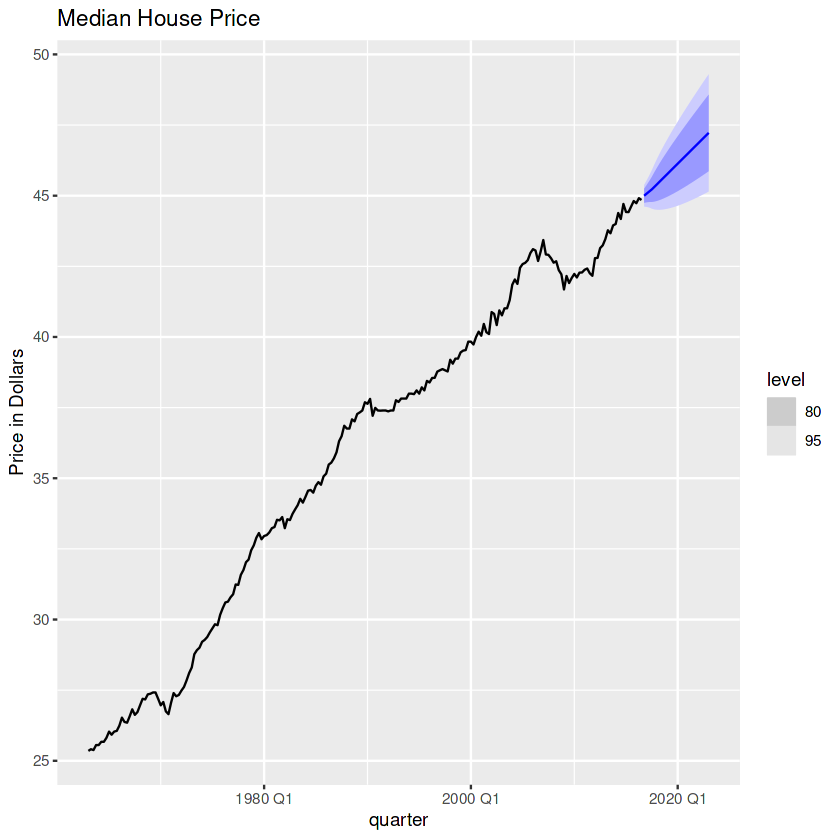

In [45]:
arima_fit %>% forecast(h=26) %>% mutate(.mean = InvBoxCox(.mean, lambda)) %>% autoplot(train_tf) + labs(title = "Median House Price", y="Price in Dollars")